# Text Message Analysis
## Overview
This project analysizes 67,093 text messages (SMSs) taken from the National University of Singapore SMS Corpus on Mar 9, 2015 and is mostly comprised of messages from Singaporeans and students attending the NUS. The objective of the project will be to do a **Sentiment Analysis** and **Frequency Insight** of the datasetto uncover emotional patterns and dominant discussion themes. With this project we'll gather insights about how text messages are used, and answer questions such as:
- Are short messages more negative than longer messages?
- Are positive messages prevalent in the dataset?
- Do positive messages contain more emojis or informal words?

## 1. Data Loading & Cleaning
The first step in this project is to load the data and get it ready for examination, so we'll start by importing the necessary libraries to run the project, import the data, and clean the dataframe.

In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Downloading aditional datasets
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Loading the data
sms = pd.read_csv('clean_nus_sms.csv')

# Confirming by printing first few rows
sms.head(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wilso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wilso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\wilso\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4


In [2]:
# Checking column data types and looking for NULL values
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


It looks like the first column is the index, so it can be eliminated, as keeping it would just be having redundant information. The data types for the columns are appropriate with the exception of `length`, which should be `int64`, so we'll correct this. This situation was likely caused by at least one of the values not being a valid integer, so we'll convert to numeric and force non-numeric values to be `NaN`. It also looks like there are only three text messages with `NULL` values, as messages without text are not meaningful for our project they will be dropped.

In [3]:
# Dropping the first column, the repeated index
sms = sms.drop(columns = "Unnamed: 0")

# Changing the datatype for the column 'length'
sms['length'] = pd.to_numeric(sms['length'], errors = 'coerce')

# Dropping rows where there are NULL values
sms = sms.dropna(how = 'any')

# Remove empty or whitespace-only messages
sms = sms[sms['Message'].str.strip() != '']

# Reset index
sms = sms.reset_index(drop=True)

# Getting summary description
sms.head(3)

,id,Message,length,country,Date
0,10120,Bugis oso near wat...,21.0,SG,2003/4
1,10121,"Go until jurong point, crazy.. Available only ...",111.0,SG,2003/4
2,10122,I dunno until when... Lets go learn pilates...,46.0,SG,2003/4


Now, we can discover some summary statistics for `length` and assess how many different countries is the dataset comprised of.

In [4]:
# Printing the summary statistics for 'length'
display(sms['length'].describe())

# Displaying the different countries in the dataset
sms['country'].value_counts()

count    48591.000000
mean        54.853594
std         53.203152
min          1.000000
25%         21.000000
50%         39.000000
75%         70.000000
max        910.000000
Name: length, dtype: float64

country
Singapore              22011
SG                      9803
India                   6901
United States           3748
USA                     1931
Sri Lanka               1017
Malaysia                 766
Pakistan                 751
unknown                  602
Canada                   198
Bangladesh               126
China                    107
india                    105
INDIA                     79
Philippines               67
Indonesia                 48
Nepal                     39
srilanka                  30
United Kingdom            30
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
UK                        10
Italia                    10
Trinidad and Tobago       10
Turkey                    10
Nigeria                   10
Macedonia                 10
New Zealand               10
Slovenia                  10
Lebanon                   10
Romania                    9
Morocco                    9
Austra

From the country list it's observable that some more cleaning must be done, namely merge coutries that are repeated twice with different capitalization and standardizing the countries' names by converting all to Title case.

In [5]:
# Merging repeated countries names
country_mapping = {
    'SG': 'Singapore',
    'Singapore': 'Singapore',
    'USA': 'United States',
    'United States': 'United States',
    'india': 'India',
    'INDIA': 'India',
    'India': 'India',
    'UK': 'United Kingdom',
    'United Kingdom': 'United Kingdom',
    'srilanka': 'Sri Lanka',
    'Sri Lanka': 'Sri Lanka',
    'Italia': 'Italy',
    'MY': 'Malaysia'  # likely Malaysia
}

# Apply the mapping, leave all other countries as-is
sms['country'] = sms['country'].map(lambda x: country_mapping.get(x, x))

# Converting all to Title case
sms['country'] = sms['country'].str.title()

# Checking results
sms['country'].value_counts()

country
Singapore              31814
India                   7085
United States           5679
Sri Lanka               1047
Malaysia                 767
Pakistan                 751
Unknown                  602
Canada                   198
Bangladesh               126
China                    107
Philippines               67
Indonesia                 48
United Kingdom            40
Nepal                     39
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Lebanon                   10
Trinidad And Tobago       10
Macedonia                 10
Turkey                    10
Nigeria                   10
Slovenia                  10
New Zealand               10
Italy                     10
Morocco                    9
Romania                    9
Australia                  9
Jamaica                    8
Barbados                   8
France                     5
Spain                      5
Name: count, dtype: int64

## 2. Preprocessing
Once the data is clean, we can start preprocessing it. The `Message` column will be lowercased and have the punctuation and stopwords removed, and we'll apply lemmatization.

In [6]:
# Loading set of stopwords
stop_words = set(stopwords.words('english'))

# Instanciating lemmatizer
lemmatizer = WordNetLemmatizer()

# Defining function that preprocesses 'Message'
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

# Processing all messages
sms['clean_message'] = sms['Message'].apply(preprocess)

## 3. Sentiment Analysis
The code is finally ready for Sentiment Analysis. In this block, we'll determine if the general sentiment of a written text message is *negative*, *neutral* or *positive* and plot it by country.

sentiment
positive    21488
neutral     21422
negative     5681
Name: count, dtype: int64


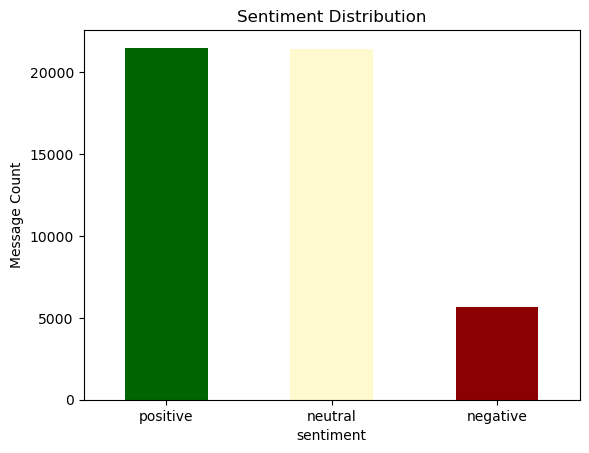

In [7]:
# Instanciating the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Calculating the sentiment score to be used for comparison
sms['sentiment_score'] = sms['Message'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Function for labeling the sentiment
def label_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Applying label
sms['sentiment'] = sms['sentiment_score'].apply(label_sentiment)

# Printing values of each sentiment
print(sms['sentiment'].value_counts())

# Plotting
# Define colors
colors = {'positive': 'darkgreen', 'neutral': 'lemonchiffon', 'negative': 'darkred'}

# Ensure consistent order
sentiment_order = ['positive', 'neutral', 'negative']

# Reindex to make sure the bars are in the order we want
sentiment_counts = sms['sentiment'].value_counts().reindex(sentiment_order)

# Plotting sentiment distribution
sentiment_counts.plot(kind='bar', color=[colors[s] for s in sentiment_order])
plt.title('Sentiment Distribution')
plt.ylabel('Message Count')
plt.xticks(rotation = 0)
plt.show()

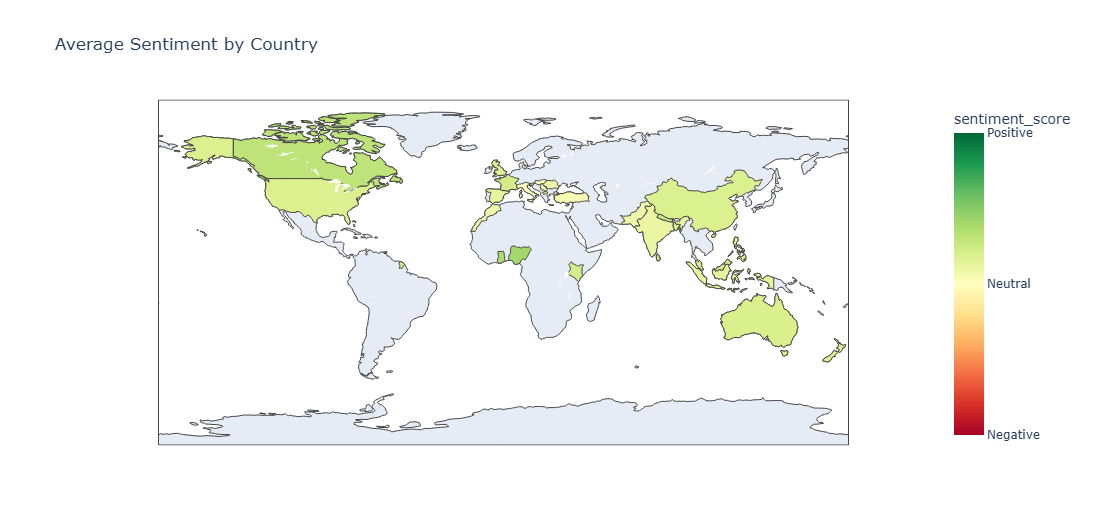

In [29]:
# Plotting world map sentiment
# Note: this library can't plot the 'Unknown' in country, as it's not linked to a mapped area

# Dataset that will be used for plotting
country_sentiment = sms.groupby('country')['sentiment_score'].mean().reset_index()

# Plotting the map
fig = px.choropleth(country_sentiment,
                     locations = 'country',
                     locationmode = 'country names', 
                     color = 'sentiment_score',
                     color_continuous_scale = 'RdYlGn', # Red = Negative, Green = Positive
                     range_color = [-1,1],
                     title = 'Average Sentiment by Country',
                     width = 900,
                     height = 525)
# Center colorbar at 0
fig.update_layout(coloraxis_colorbar=dict(tickvals=[-1,0,1], ticktext=['Negative','Neutral','Positive']))
fig.show()

In both the plot and the written analysis it's possible to observe that both the positive and neutral sentiments dominate the dataset, and with a very similar count with 21488 text messages classified as being positive and 21429 classified as neutral, and only 5681 text messages being classified as negative. This shows that the average text message has a neutral or positive tone to it.<br>
Looking at the geographical map of the dataset, Nigeria and Ghana had the most positive sentiment, followed by Canada, but overall the general sentiment across all countries is positive, which was expected based on the average sentiment represented in the sentiment distribution.<br>
Next we'll find out if the message lenght has any impact on the sentiment, or vice-versa.

sentiment
negative    66.154374
neutral     36.995379
positive    69.669257
Name: length, dtype: float64


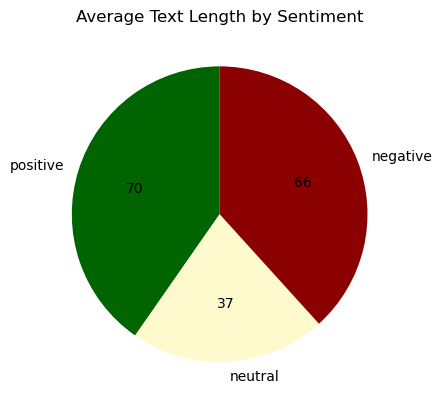

In [28]:
# Printing the average length by sentiment
length_by_sent = sms.groupby('sentiment')['length'].mean()

print(length_by_sent)

# Define colors 
colors = {'positive': 'darkgreen', 'neutral': 'lemonchiffon', 'negative': 'darkred'}

# Ensure consistent order
sentiment_order = ['positive', 'neutral', 'negative']

# Reindex your Series so it matches the order
length_by_sent = length_by_sent.reindex(sentiment_order)

# Prepare actual values for labels
values = [int(round(v)) for v in length_by_sent.values]

# Plotting text lenght by sentiment
length_by_sent.plot(kind = 'pie', colors = [colors[s] for s in sentiment_order],
                    labels=sentiment_order, # ensure slice labels
                    autopct=lambda pct, allvals=values: str(allvals.pop(0)), # show actual value
                    startangle=90)
plt.title('Average Text Length by Sentiment')
plt.ylabel('')
plt.show()

Text messages with positive conotation are usually longer, averaging 70 characters, while messages with negative sentiment are very close, averaging 66 characters. Neutral messages tend to be shorter, averaging 37 characters.

## 4. Word Importance
To verify which ones were the most important words based on their frequency, this project will use Term Frequency-Inverse Document Frequency (TF-IDF) as an approach, giving more weight to unique and more informative words and reducing the weight of more common ones.

In [10]:
# Instanciating the vectorizer
vectorizer = TfidfVectorizer(max_features = 30)

# Fitting and transforming the messages
X = vectorizer.fit_transform(sms['clean_message'])

# Getting the most used words
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

['come' 'dont' 'dun' 'get' 'go' 'going' 'good' 'got' 'haha' 'hahaha' 'hey'
 'home' 'im' 'know' 'later' 'le' 'like' 'lol' 'need' 'oh' 'ok' 'okay'
 'one' 'see' 'still' 'think' 'time' 'ur' 'want' 'yeah']


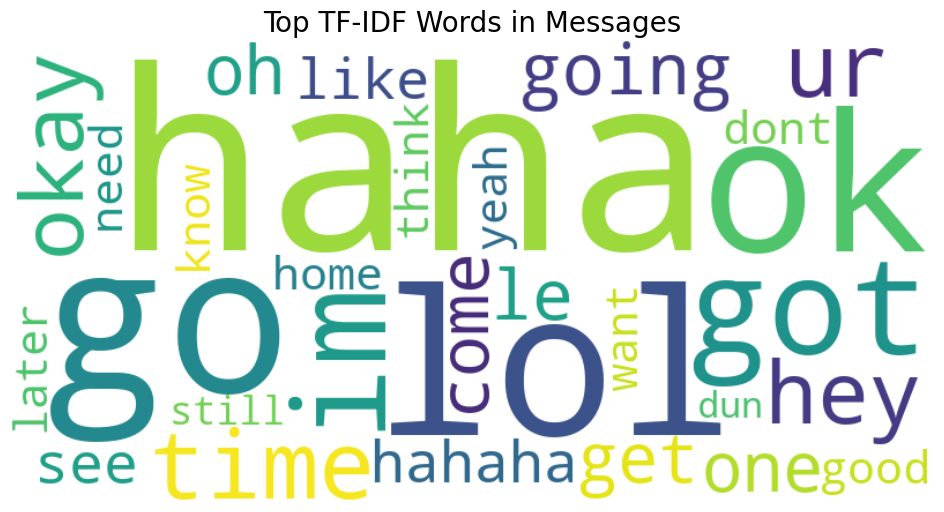

In [11]:
# Plotting wordcloud

# Converting TF-IDF features to a dictionary (word: score)
tfidf_scores = X.toarray().sum(axis = 0) # sum across all messages
word_scores = dict(zip(feature_names, tfidf_scores))

# Create wordcloud
wordcloud = WordCloud(width = 800,
                      height = 400,
                      background_color = 'white',
                      colormap = 'viridis').generate_from_frequencies(word_scores)
# Plotting
plt.figure(figsize = (12,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top TF-IDF Words in Messages', fontsize = 20)
plt.show()

On the wordcloud above, the 30 most importat words from the corpus are represented, with most used ones being larger. Several inferences can be obtaining from looking at this wordcloud:
- Casual conversation tone - There are several words showing that people are using informal chat language, such as 'haha,', 'lol', 'ok', etc.
- Interactions are task or plan oriented - As can be seen by the use of several verbs such as 'go', 'come', 'get', etc.
- Time coordination - The appearance of words such as 'later', 'time', 'still', etc. show that coordination or scheduling is a frequent topic.
- Positive or filler expressions - The use of positive or filler words again emphasize an informal, friendly style is commonly used.

## 5. Findings and Conclusion
This analysis of the NUS SMS dataset provides insight into typical messaging patterns. Overall, the text messages tend to be informal and conversational, as seen in the prevalence of positive, friendly words. Sentiment analysis shows more messages classified as positive than negative, and a small difference from the positive sentiment messages to the neutral ones. Average message length varies by sentiment, with positive messages slightly longer than negative ones, but both much longer than neutral ones, suggesting more elaboration when expressing strong emotions.

At the country level, sentiment scores indicate that most countries exhibit slightly positive messaging behavior, though the sample size varies greatly between regions. Visualizations such as pie charts for text length, wordclouds, and a choropleth map helped illustrate these patterns clearly.

Limitations: The dataset contains messages primarily from Singapore and students, so findings may not generalize globally. Additionally, sentiment analysis tools may misclassify slang, abbreviations, or mixed-language messages.

## 6. Future Work
There are several ways this analysis could be extended: Perform topic modeling to uncover the most common conversation themes and see how they vary by sentiment or country, or explore temporal trends, such as how message sentiment or frequency changes over time or across different hours of the day.

Incorporating more advanced NLP models, like transformer-based embeddings (e.g., BERT), could improve sentiment classification, especially for slang, abbreviations, or mixed-language messages.

Finally, expanding the dataset to include more countries, languages, or user demographics would allow for cross-cultural comparisons and more generalizable insights, making the analysis richer and more applicable to real-world messaging behavior.